In [6]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime

In [7]:
df = pd.read_csv('weather_sample.csv',index_col='年月日',encoding='shift_jis',parse_dates=True)
df = df[['平均気温(℃)']]
df_week = df.resample('W').mean()
df_week

,平均気温(℃)
年月日,
2012-01-01,5.700000
2012-01-08,5.900000
2012-01-15,5.342857
2012-01-22,4.642857
2012-01-29,3.428571
...,...
2021-12-05,10.414286
2021-12-12,9.957143
2021-12-19,7.057143


In [8]:
#0-1にスケーリング
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df_week_scale = pd.DataFrame(scaler.fit_transform(df_week),index=df_week.index,columns=df_week.columns)

In [9]:
#学習データ、試験データに分離
df_week_scale_train = df_week_scale['2012':'2020']
df_week_scale_test = df_week_scale['2021']

C:\Users\hahih\AppData\Local\Temp/ipykernel_12420/181572454.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  df_week_scale_test = df_week_scale['2021']


In [11]:
df_week_scale_train

,平均気温(℃)
年月日,
2012-01-01,0.135602
2012-01-08,0.142505
2012-01-15,0.123274
2012-01-22,0.099112
2012-01-29,0.057199
...,...
2020-11-29,0.353550
2020-12-06,0.236686
2020-12-13,0.292406


In [10]:
look_back = 30 #どれくらい過去まで見るか

def create_input_data(data, look_back):    
    raw_data = data.T.values.tolist()
    data_size = len(data) - look_back

    X = [[] for i in range(len(raw_data))] 
    y = [[] for i in range(len(raw_data))] 

    for i in range(data_size):
        for j in range(len(raw_data)):
            X[j].append(raw_data[j][i:i + look_back])
            y[j].append([raw_data[j][i + look_back]])

    X_tmp = X[-1]
    y_tmp = y[-1]
    
    for i in range(len(raw_data)-1):
        X_tmp = np.insert(X_tmp,np.arange(0, (look_back-1)*(i+1)+1, i+1),X[-i-2],axis=1)
        y_tmp = np.insert(y_tmp,np.arange(0, (i+1), i+1),y[-i-2],axis=1)
    
    X = np.array(X_tmp).reshape(data_size, look_back, len(raw_data))
    y = np.array(y_tmp).reshape(data_size, 1, len(raw_data))
    
    return y, X

y_train,X_train = create_input_data(
    data=df_week_scale_train,
    look_back=look_back
)

y_test,X_test = create_input_data(
    data=df_week_scale_test,
    look_back=look_back
)

In [13]:
X_train

array([[[0.13560158],
        [0.14250493],
        [0.12327416],
        ...,
        [0.77071006],
        [0.87672584],
        [0.81163708]],

       [[0.14250493],
        [0.12327416],
        [0.09911243],
        ...,
        [0.87672584],
        [0.81163708],
        [0.93885602]],

       [[0.12327416],
        [0.09911243],
        [0.05719921],
        ...,
        [0.81163708],
        [0.93885602],
        [0.9566075 ]],

       ...,

       [[0.67504931],
        [0.5147929 ],
        [0.66518738],
        ...,
        [0.52218935],
        [0.3535503 ],
        [0.23668639]],

       [[0.5147929 ],
        [0.66518738],
        [0.72978304],
        ...,
        [0.3535503 ],
        [0.23668639],
        [0.29240631]],

       [[0.66518738],
        [0.72978304],
        [0.77317554],
        ...,
        [0.23668639],
        [0.29240631],
        [0.13510848]]])

In [4]:
#モデル定義
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

In [11]:
model = Sequential()
x = model.add(LSTM(10, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(8))
model.add(Dense(len(df.columns))) #出力層はデータ数に合わせる

model.compile(loss='mean_squared_error', optimizer='adam')

In [12]:
X_train.shape

(440, 30, 1)

In [13]:
history = model.fit(X_train, y_train, epochs=50, batch_size=1)

Epoch 1/50
440/440 [==============================] - 21s 27ms/step - loss: 0.0331
Epoch 2/50
440/440 [==============================] - 12s 27ms/step - loss: 0.0064
Epoch 3/50
440/440 [==============================] - 12s 27ms/step - loss: 0.0056
Epoch 4/50
440/440 [==============================] - 11s 26ms/step - loss: 0.0055
Epoch 5/50
440/440 [==============================] - 11s 24ms/step - loss: 0.0055
Epoch 6/50
440/440 [==============================] - 12s 28ms/step - loss: 0.0052
Epoch 7/50
440/440 [==============================] - 12s 27ms/step - loss: 0.0051
Epoch 8/50
440/440 [==============================] - 11s 26ms/step - loss: 0.0050
Epoch 9/50
440/440 [==============================] - 12s 26ms/step - loss: 0.0046
Epoch 10/50
440/440 [==============================] - 12s 26ms/step - loss: 0.0047
Epoch 11/50
440/440 [==============================] - 12s 27ms/step - loss: 0.0045
Epoch 12/50
440/440 [==============================] - 12s 27ms/step - loss: 0.0044
E

In [15]:
model.evaluate(X_test,y_test,batch_size=1)

22/22 [==============================] - 2s 7ms/step - loss: 0.0044


0.004389405716210604

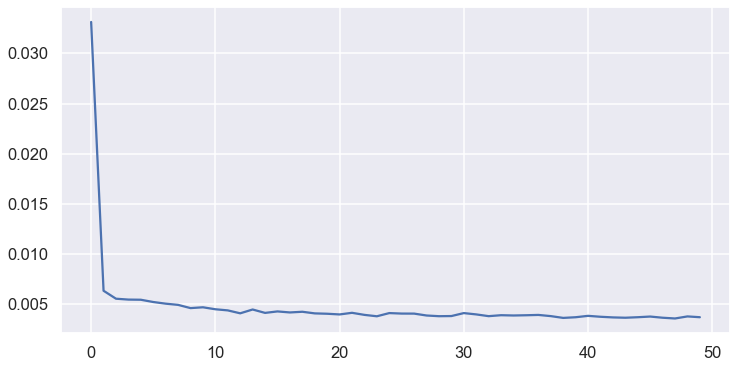

In [14]:
sns.set(context="talk")
fig = plt.subplots(figsize=(12,6))
plt.plot(history.history['loss'])

1/1 [==============================] - 0s 72ms/step


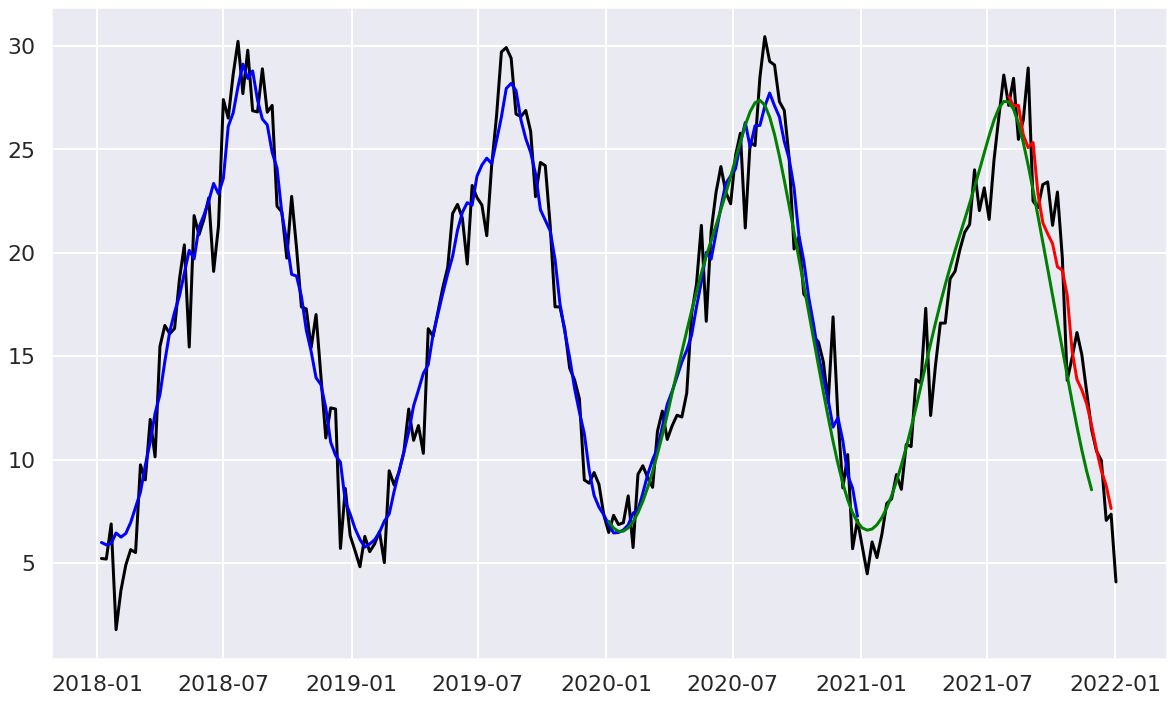

In [17]:
sns.set(context="poster",font="Hiragino Maru Gothic Pro")
fig = plt.subplots(figsize=(20,12))

#正解のプロット
df_week = pd.DataFrame(scaler.inverse_transform(df_week_scale),
                       index=df_week.index,columns=df_week.columns)
plt.plot(df_week["2018":]["平均気温(℃)"],color="black")

#学習用データ予測結果のプロット
df_week_train_pred = pd.DataFrame(scaler.inverse_transform(model.predict(X_train)),
                                  index=df_week_scale_train.index[look_back:],columns=df_week_scale_train.columns)
plt.plot(df_week_train_pred["2018":]["平均気温(℃)"],color="blue")

#評価用データ予測結果のプロット
df_week_test_pred = pd.DataFrame(scaler.inverse_transform(model.predict(X_test)),
                                 index=df_week_scale_test.index[look_back:],columns=df_week_scale_test.columns)
plt.plot(df_week_test_pred["2018":]["平均気温(℃)"],color="red")

#未来予測
future_steps = 100
X_future = [df_week_scale_test[-look_back:].values.tolist()]
y_future_list = []

for step in range(future_steps):
    y_future = model.predict(X_future)
    y_future_list.append(y_future[0])
    X_future = [X_future[0][1:] + y_future.tolist()]
    
df_week_future = pd.DataFrame(scaler.inverse_transform(y_future_list),
                              index=pd.date_range('2020-01-01', periods=future_steps, freq='W'),columns=df_week.columns)
plt.plot(df_week_future["2019":]["平均気温(℃)"],color="green")